# Deep Learning Assignment-3

### Name : Shrenik Ganguli
### Roll No : CS23MTECH14014

#### Importing the necessary packages

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

#### Loading the training and testing datasets

In [2]:
# Loading the CIFAR-10 dataset

train_dataset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar10-python', train=True,
                                            download=False)

test_dataset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar10-python', train=False,
                                            download=False)

#### Normalising the images with mean and standard deviation

In [3]:
# Defining individual transformations
transform = transforms.ToTensor()
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

# Applying transformations to the dataset
train_dataset.transform = transforms.Compose([transform, normalize])
test_dataset.transform  = transforms.Compose([transform, normalize])

#### Printing one image from each class in the training dataset

In [4]:
# Classes in CIFAR-10
labels_dictionary = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

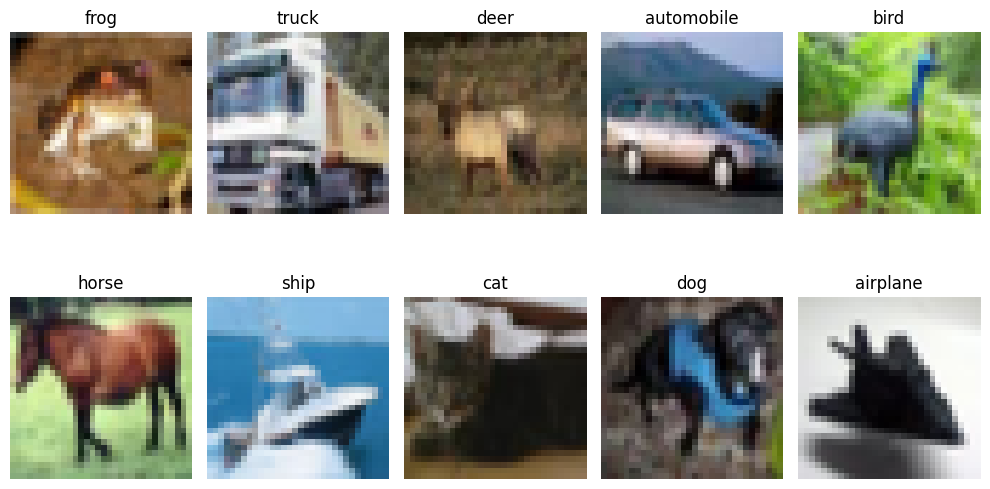

In [5]:
# Finding the index of the first occurrence of each class
class_indices = {}
for idx, (_, label) in enumerate(train_dataset):
    if label not in class_indices:
        class_indices[label] = idx
        
# Plot one image from each class
plt.figure(figsize=(10, 6))
for i, (class_name, idx) in enumerate(class_indices.items()):
    image, _ = train_dataset[idx]
    image = image.numpy().transpose((1, 2, 0))
    plt.subplot(2, 5, i + 1)
    plt.imshow((image / 2 + 0.5))
    plt.title(labels_dictionary[class_name])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Creating data loaders

In [6]:
# Define data loaders to iterate through the datasets in batches
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,  num_workers=4)
test_loader = DataLoader(test_dataset,   batch_size=64,  shuffle=False, num_workers=2)

print(f'Number of training batches = {len(train_loader)}')
print(f'Number of testing batches  = {len(test_loader)}')

Number of training batches = 196
Number of testing batches  = 157


#### Setting the device to GPU

In [7]:
# Initialize the PyTorch device to either CUDA (GPU) if available or CPU if not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## PART-1: Self-Attention for Object Recognition with CNNs

#### The Self Attention Layer

In [8]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionLayer, self).__init__()
        
        # Define the query, key, and value transformations
        self.Wq = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.Wk = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.Wv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Learnable parameter for scaling the attention scores
        self.gamma = nn.Parameter(torch.zeros(1))

        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Linear projections computing query, key, and value
        Q = self.Wq(x).view(batch_size, -1, width*height).permute(0, 2, 1) # B x (C//8) x (H*W)
        K = self.Wk(x).view(batch_size, -1, width*height) # B x (C//8) x (H*W)
        V = self.Wv(x).view(batch_size, -1, width*height) # B x C x (H*W)
        
        # Compute scaled dot-product attention scores
        QKT = torch.bmm(Q, K)
        attention = F.softmax(QKT, dim=-1) # B x (H*W) x (H*W)
        
        # Apply attention to value
        Ypred = torch.bmm(V, attention.permute(0, 2, 1))
        
        # Reshape, scale and add it to the input
        Ypred = Ypred.view(batch_size, channels, height, width) # B x C x H x W
        Ypred = self.gamma * Ypred + x # residual connection
        
        return Ypred

#### Implementing the CNN with the self attention layer

In [9]:
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()

        # Define convolutional layers
        self.conv_layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.attention_layer1 = SelfAttentionLayer(64)
        self.conv_layer2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.attention_layer2 = SelfAttentionLayer(128)
        self.conv_layer3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.attention_layer3 = SelfAttentionLayer(256)
        self.conv_layer4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.attention_layer4 = SelfAttentionLayer(512)
        self.conv_layer5 = nn.Conv2d(512, 10, kernel_size=3, stride=1, padding=1)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Pass through convolutional layers
        x = F.relu(self.conv_layer1(x))
        x = self.attention_layer1(x)
        x = F.relu(self.conv_layer2(x))
        x = self.attention_layer2(x)
        x = F.relu(self.conv_layer3(x))
        x = self.attention_layer3(x)
        x = F.relu(self.conv_layer4(x))
        x = self.attention_layer4(x)
        x = self.conv_layer5(x)
        
        # Apply global average pooling
        x = self.global_avg_pooling(x)
        
        # Flatten and return
        x = x.view(-1, 10)
        return x

#### Initialising the Model

In [10]:
cnn_model = CNNWithSelfAttention()
cnn_model.to(device) # GPU

CNNWithSelfAttention(
  (conv_layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention_layer1): SelfAttentionLayer(
    (Wq): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (Wk): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (Wv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention_layer2): SelfAttentionLayer(
    (Wq): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (Wk): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (Wv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layer3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention_layer3): SelfAttentionLayer(
    (Wq): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (Wk): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (Wv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layer4): Conv2d(256, 512, kernel_si

#### Setting the hyperparameters (Learning Rate, Number of Epochs)

In [11]:
# Setting Learning Rate to an appropriate value
learning_rate = 0.00175

# Setting the maximum number of epochs
num_epochs = 40

#### Using Adam optimizer

In [12]:
# Define the Adam optimizer
cnn_adam_optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)
print(cnn_adam_optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00175
    maximize: False
    weight_decay: 0
)


#### Initialising a loss dictionary to store training loss values and the cross-entropy loss function

In [13]:
# Initialize a dictionary to store average loss value computed after each iteration
cnn_loss_dictionary = {}

# Using cross entropy loss as loss function
loss_function = nn.CrossEntropyLoss()
print("Loss Function used is",loss_function)

Loss Function used is CrossEntropyLoss()


#### Training the model

In [14]:
def train_model(model, data_loader, optimizer, criterion, num_epochs=10):
    
    # The model enters training state
    model.train()
    
    # Dictionary to record average epoch loss
    loss_history = {}
    
    # Training the model the number of epoch times
    for epoch in range(num_epochs):
        #print(f"\n ------------------------- Epoch {epoch+1} ------------------------- \n")
        
        # Initialising the epoch loss at every iteration
        running_loss = 0.0
        
        # Enumerationg over the data loader
        for batch_idx, (batch_images, batch_labels) in enumerate(data_loader, 1):
            
            # Sending the training images to the GPU
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            # Calculating the gradient
            optimizer.zero_grad()
            
            # Predicting the model output
            batch_outputs = model(batch_images)
            
            # Computing the cross-entropy loss for the current batch
            batch_loss = criterion(batch_outputs, batch_labels)
            
            # Backpropagating the loss during training
            batch_loss.backward()
            optimizer.step()
            
            # Summing the batch loss in each epoch
            running_loss += batch_loss.item()
            
            # Printing the batch loss for each epoch
            #print(f" |\t Batch {batch_idx} \t | \tLoss = {batch_loss.item()} \t| ")
            
        # Recording and printing the average loss in one epoch over all the batches
        loss_history[epoch] = running_loss / batch_idx
        #print(f"\n Average Loss = {loss_history[epoch]}")
        print(f"|\t Epoch {epoch+1} \t | \tLoss = {loss_history[epoch]} \t|")
        print("-" * 65)
        
    return loss_history

cnn_loss_dictionary = train_model(cnn_model, train_loader, cnn_adam_optimizer, loss_function, num_epochs)

|	 Epoch 1 	 | 	Loss = 1.7811381993245106 	|
-----------------------------------------------------------------
|	 Epoch 2 	 | 	Loss = 1.3855602412807697 	|
-----------------------------------------------------------------
|	 Epoch 3 	 | 	Loss = 1.1478995729465873 	|
-----------------------------------------------------------------
|	 Epoch 4 	 | 	Loss = 0.998692934914511 	|
-----------------------------------------------------------------
|	 Epoch 5 	 | 	Loss = 0.8709617628126728 	|
-----------------------------------------------------------------
|	 Epoch 6 	 | 	Loss = 0.7866354548201269 	|
-----------------------------------------------------------------
|	 Epoch 7 	 | 	Loss = 0.715186844370803 	|
-----------------------------------------------------------------
|	 Epoch 8 	 | 	Loss = 0.6408472108293553 	|
-----------------------------------------------------------------
|	 Epoch 9 	 | 	Loss = 0.5865364190267057 	|
-----------------------------------------------------------------
|	 

#### Testing the accuracy of the trained model

In [15]:
def test_model(model, test_loader):
    
    # Model enters testing phase
    model.eval()
    
    # Initialising accuracy, correct predictions and total samples to 0
    accuracy = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        
        for images, labels in test_loader:
            
            images, labels = images.to(device), labels.to(device) # GPU computations
            
            # Output from the trained model
            outputs = model(images)
            
            # Applying softmax to the outputs
            probabilities = F.softmax(outputs, dim=1)
            
            # Predicted label will be the one with highest probability obtained after softmax
            _, predicted = torch.max(probabilities, 1)
            
            # Updating total_samples and correct_predictions
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    # Calculating accuracy
    accuracy = correct_predictions / total_samples
    return(accuracy)


test_result = test_model(cnn_model, test_loader)
print(f"Test Accuracy using CNN with Self-Attention: {test_result*100}%")

Test Accuracy using CNN with Self-Attention: 73.32%


#### Plotting graph for Training Loss vs Epochs

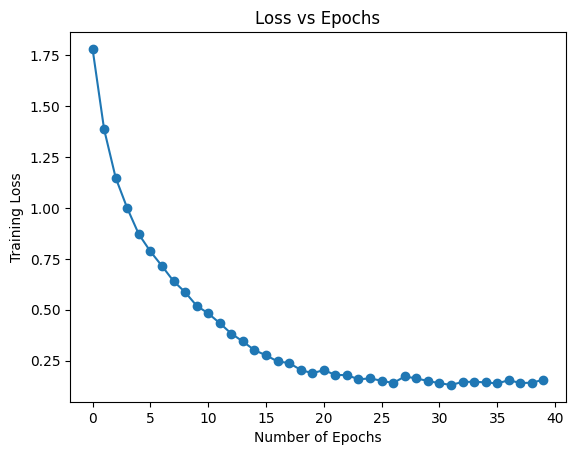

In [16]:
def plot_training_loss(loss_history):
    
    # Setting the axes as no. of epochs (X-axis) and corresponding loss value (Y-axis)
    epochs = list(loss_history.keys())
    losses = list(loss_history.values())

    # Plot the graph
    plt.plot(epochs, losses, marker='o')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')
    plt.title('Loss vs Epochs')
    plt.grid(False)
    plt.show()
    

plot_training_loss(cnn_loss_dictionary)

## PART-2: Object Recognition with Vision Transformer

#### Split image into patches and then embed them.

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels=3, embedding_dim=256):
        super().__init__()
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        # Projection layer to embed patches
        self.projection = nn.Conv2d(
            in_channels,
            embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        # Projecting input images into patches
        x = self.projection(x)                # (batch_size, embedding_dim, num_patches ** 0.5, num_patches ** 0.5)
        x = x.flatten(2)                      # (batch_size, embedding_dim, num_patches)
        x = x.transpose(1, 2)                 # (batch_size, num_patches, embedding_dim)

        return x

#### Attention mechanism

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dimension, num_heads=12, qkv_bias=True, attention_dropout=0., projection_dropout=0.):
        super().__init__()
        
        # Number of attention heads
        self.num_heads = num_heads
        # Dimension of input and output vectors
        self.dimension = dimension
        # Dimension of each head
        self.head_dimension = dimension // num_heads
        # Scaling factor for dot product attention
        self.scale = 1.0 / torch.sqrt(torch.tensor(self.head_dimension, dtype=torch.float32))

        # Linear transformation for query, key, and value
        self.query_key_value = nn.Linear(dimension, dimension * 3, bias=qkv_bias)
        # Dropout layer for attention weights
        self.attention_dropout = nn.Dropout(attention_dropout)
        # Linear transformation for projecting back to original dimension
        self.projection = nn.Linear(dimension, dimension)
        # Dropout layer for projection
        self.projection_dropout = nn.Dropout(projection_dropout)
        
        
    def forward(self, x):

        batch_size, sequence_length, dimension = x.shape

        if dimension != self.dimension:
            raise ValueError("Input dimension doesn't match model dimension.")

        qkv = self.query_key_value(x)  # (batch_size, sequence_length, 3 * dimension)
        qkv = qkv.view(
                batch_size, sequence_length, 3, self.num_heads, self.head_dimension
        )  # (batch_size, sequence_length, 3, num_heads, head_dimension)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, batch_size, num_heads, sequence_length, head_dimension)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_transpose = k.transpose(-2, -1)  # (batch_size, num_heads, head_dimension, sequence_length)
        scaled_dot_product = (q @ k_transpose) * self.scale  # (batch_size, num_heads, sequence_length, sequence_length)
        attention_weights = torch.nn.functional.softmax(scaled_dot_product, dim=-1)  # (batch_size, num_heads, sequence_length, sequence_length)
        attention_weights = self.attention_dropout(attention_weights)

        weighted_avg = attention_weights @ v  # (batch_size, num_heads, sequence_length, head_dimension)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (batch_size, sequence_length, num_heads, head_dimension)                        # Concatenating all head outputs
        weighted_avg = weighted_avg.flatten(2)  # (batch_size, sequence_length, dimension)

        x = self.projection(weighted_avg)  # (batch_size, sequence_length, dimension)           # Multiply by W_output
        x = self.projection_dropout(x)  # (batch_size, sequence_length, dimension)

        return x

#### Multilayer perceptron

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.):
        super().__init__()
        
        # Fully connected layer from input to hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # GELU activation function
        self.activation = nn.GELU()
        # Fully connected layer from hidden to output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        # Feedforward pass through the MLP layers
        x = self.fc1(x)               # (batch_size, sequence_length, hidden_size)
        x = self.activation(x)        # (batch_size, sequence_length, hidden_size)
        x = self.dropout(x)           # (batch_size, sequence_length, hidden_size)
        x = self.fc2(x)               # (batch_size, sequence_length, output_size)
        x = self.dropout(x)           # (batch_size, sequence_length, output_size)

        return x

#### Transformer block

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, dimension, num_heads, mlp_ratio=4.0, qkv_bias=True, dropout_prob=0., attention_dropout=0.):
        super().__init__()
        # Layer normalization for the self-attention mechanism
        self.norm1 = nn.LayerNorm(dimension, eps=1e-6)
        # Multi-head self-attention mechanism
        self.attention = MultiHeadAttention(
                dimension,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                attention_dropout=attention_dropout,
                projection_dropout=dropout_prob
        )
        # Layer normalization for the MLP
        self.norm2 = nn.LayerNorm(dimension, eps=1e-6)
        # Multi-layer perceptron (MLP) for feed-forward processing
        hidden_dimension = int(dimension * mlp_ratio)
        self.mlp = MLP(
                input_size=dimension,
                hidden_size=hidden_dimension,
                output_size=dimension,
                dropout_prob=dropout_prob
        )

    def forward(self, x): # Forward pass through the Transformer block
        
        # Self-attention layer with layer normalization and residual connection
        x = x + self.attention(self.norm1(x))
        # Feed-forward MLP layer with layer normalization and residual connection
        x = x + self.mlp(self.norm2(x))

        return x

#### Vision Transformer

In [21]:
class VisionTransformer(nn.Module):
    def __init__(
            self,
            image_size=32,
            patch_size=8,
            in_channels=3,
            num_classes=10,
            embedding_dimension=64,
            depth=8,
            num_heads=8,
            mlp_ratio=2.,
            qkv_bias=True,
            dropout_prob=0.2,
            attention_dropout=0.2,
    ):
        super().__init__()

        # Patch embedding layer
        self.patch_embed = PatchEmbedding(
                image_size=image_size,
                patch_size=patch_size,
                in_channels=in_channels,
                embedding_dim=embedding_dimension,
        )
        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dimension))
        # Positional embedding
        self.positional_embed = nn.Parameter(
                torch.zeros(1, self.patch_embed.num_patches + 1, embedding_dimension)
        )
        # Dropout layer for positional embeddings
        self.positional_dropout = nn.Dropout(p=dropout_prob)

        # Transformer blocks
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    dimension=embedding_dimension,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    dropout_prob=dropout_prob,
                    attention_dropout=attention_dropout,
                )
                for _ in range(depth)
            ]
        )

        # Layer normalization after the transformer blocks
        self.normalization = nn.LayerNorm(embedding_dimension, eps=1e-6)
        # Final classification layer
        self.classifier = nn.Linear(embedding_dimension, num_classes)


    def forward(self, x):
        batch_size = x.shape[0]
        # Patch embedding
        x = self.patch_embed(x)

        # Expand class token to match batch size
        class_token = self.class_token.expand(
                batch_size, -1, -1
        )  # (batch_size, 1, embedding_dimension)
        # Concatenate class token with patch embeddings
        x = torch.cat((class_token, x), dim=1)  # (batch_size, 1 + num_patches, embedding_dimension)
        # Add positional embeddings
        x = x + self.positional_embed[:, :x.size(1)]  # Ensure positional_embed matches the size of x
        # Apply dropout to positional embeddings
        x = self.positional_dropout(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply layer normalization
        x = self.normalization(x)

        # Extract class token for classification
        class_token_final = x[:, 0]  # Extracting only the class token
        # Classification layer
        x = self.classifier(class_token_final)

        return x

#### Initialise the model and optimizer

In [22]:
# Initilalising a loss dictionary to store epoch loss values
vit_loss_dictionary = {}

# Initialise the vision transformer model
vit_model = VisionTransformer()
print(vit_model)
vit_model.to(device) #GPU

print("\n")

# Define the Adam optimizer
vit_adam_optimizer = torch.optim.Adam(vit_model.parameters(), lr = learning_rate)
print(vit_adam_optimizer)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 64, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TranformerBlock(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=128, out_features=64, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=64, out_features=10, bias=True)
)


#### Training the model

In [23]:
def train(model, train_loader, optimizer, criterion, epochs=25):
    model.train()
    loss_history = {}
    for epoch in range(epochs):        
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # For printing batch-wise loss if needed
            #print(f" Batch {batch_idx} Loss = {loss.item()} ")

            
        avg_loss = running_loss / batch_idx
        loss_history[epoch] = avg_loss
        print(f"|\t Epoch {epoch + 1} \t | \tLoss = {loss_history[epoch]} \t|")
        print("-" * 65)
        
    return loss_history


vit_loss_dictionary = train(vit_model, train_loader, vit_adam_optimizer, loss_function, num_epochs)

|	 Epoch 1 	 | 	Loss = 1.8631933416639055 	|
-----------------------------------------------------------------
|	 Epoch 2 	 | 	Loss = 1.6467049000214558 	|
-----------------------------------------------------------------
|	 Epoch 3 	 | 	Loss = 1.5078237671024945 	|
-----------------------------------------------------------------
|	 Epoch 4 	 | 	Loss = 1.420373957376091 	|
-----------------------------------------------------------------
|	 Epoch 5 	 | 	Loss = 1.3504895063079134 	|
-----------------------------------------------------------------
|	 Epoch 6 	 | 	Loss = 1.3074578442135636 	|
-----------------------------------------------------------------
|	 Epoch 7 	 | 	Loss = 1.2640460115306231 	|
-----------------------------------------------------------------
|	 Epoch 8 	 | 	Loss = 1.2248631533311338 	|
-----------------------------------------------------------------
|	 Epoch 9 	 | 	Loss = 1.184826906846494 	|
-----------------------------------------------------------------
|	 

#### Testing the model

In [24]:
def test(model, test_loader):
    model.eval()
    
    correct = 0
    total   = 0
    
    with torch.no_grad():
        for image, label in test_loader:
        
            image, label = image.to(device), label.to(device) # GPU
            
            # Forward pass
            output = model(image)
            
            # Get predicted labels
            _, predicted = torch.max(output, 1)
            
            # Update total count
            total += label.size(0)
            # Update correct count
            correct += (predicted == label).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

# Test the model
test_result = test(vit_model, test_loader)
# Print test accuracy
print(f'Test Accuracy using Vision Transformer: {test_result*100}%')


Test Accuracy using Vision Transformer: 68.05%


#### Plot Training Loss vs Epochs

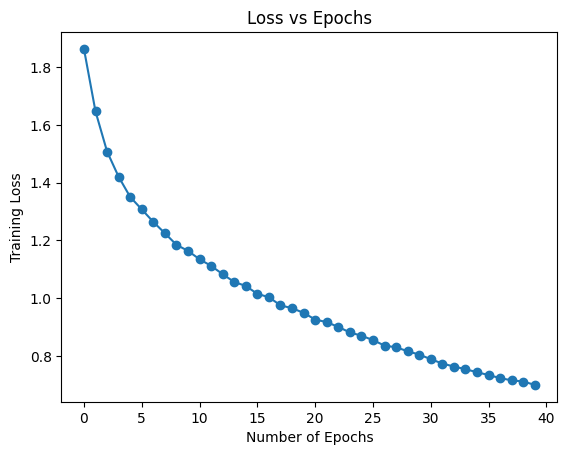

In [25]:
plot_training_loss(vit_loss_dictionary)

#### Comparing the Loss curves of both models

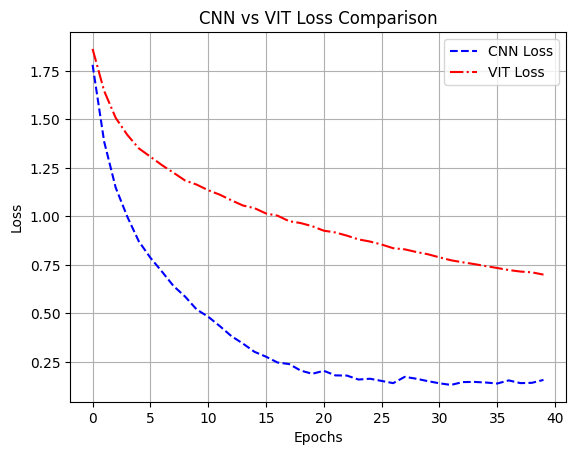

In [26]:
def plot_loss_comparison(cnn_loss_dict, vit_loss_dict):
    
    # Extracting epochs and loss values from dictionaries
    cnn_epochs, cnn_loss_values = list(cnn_loss_dict.keys()), list(cnn_loss_dict.values())
    vit_epochs, vit_loss_values = list(vit_loss_dict.keys()), list(vit_loss_dict.values())

    # Plotting the curves
    plt.plot(cnn_epochs, cnn_loss_values, label='CNN Loss', linestyle='dashed' , color='blue')
    plt.plot(vit_epochs, vit_loss_values, label='VIT Loss', linestyle='dashdot', color='red')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN vs VIT Loss Comparison')
    plt.legend()  # Show legend

    # Displaying the plot
    plt.grid(True)
    plt.show()


    
plot_loss_comparison(cnn_loss_dictionary, vit_loss_dictionary)

## Final Observation

As we can see from the above graphs, for the same number of epochs and learning rate, CNN with self-attention takes greater time and provides greater accuracy (**73.32%**), whereas the Vision Transformer with multi-headed attention is faster due to parallel computations but provides lesser accuracy (**68.05%**) on the test dataset.